In [7]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video
from tetris_gymnasium.envs.tetris import Tetris

### **Wrapper**

In [8]:
import gymnasium as gym
import numpy as np

class TetrisObsWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        # Define final observation space (4 channels, 24x18)
        self.observation_space = gym.spaces.Box(
            low=0,
            high=1,
            shape=(4, 24, 18),
            dtype=np.float32,
        )

    def observation(self, obs):
        board = obs["board"].astype(np.float32) / 9.0
        mask = obs["active_tetromino_mask"].astype(np.float32)
        holder = obs["holder"].astype(np.float32) / 9.0
        queue = obs["queue"].astype(np.float32) / 9.0

        # pad holder to (24, 18)
        holder_padded = np.zeros((24, 18), dtype=np.float32)
        holder_padded[:holder.shape[0], :holder.shape[1]] = holder

        # pad or crop queue safely to fit (24, 18)
        queue_padded = np.zeros((24, 18), dtype=np.float32)
        h, w = queue.shape
        queue_padded[:min(4, h), :min(18, w)] = queue[:min(4, h), :min(18, w)]

        # stack all channels
        stacked = np.stack([board, mask, holder_padded, queue_padded], axis=0)
        return stacked


### **Neural Network (DQN)**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super(DQN, self).__init__()
        C, H, W = obs_shape  # e.g. (4, 24, 18)

        # Safer kernel/stride combo for small inputs
        self.conv = nn.Sequential(
            nn.Conv2d(C, 32, kernel_size=3, stride=1, padding=1),  # keeps 24x18
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # halves size
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # halves again
            nn.ReLU(),
        )

        # Automatically compute flattened conv output size
        with torch.no_grad():
            dummy = torch.zeros(1, C, H, W)
            conv_out = self.conv(dummy)
            conv_out_size = conv_out.view(1, -1).size(1)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


### **ReplayBuffer**

In [10]:
class ReplayMemory:
    def __init__(self, capacity, device):
        self.memory = deque(maxlen=capacity)
        self.device = device  # 'cuda' or 'cpu'

    def push(self, state, action, reward, next_state, done):
        # Store raw (numpy or list) to save memory instead of storing tensors directly
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors and pin memory for faster GPU transfer
        states = torch.tensor(np.array(states), dtype=torch.float32).pin_memory()
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32).pin_memory()
        actions = torch.tensor(actions, dtype=torch.long).pin_memory()
        rewards = torch.tensor(rewards, dtype=torch.float32).pin_memory()
        dones = torch.tensor(dones, dtype=torch.float32).pin_memory()

        # Transfer to GPU asynchronously for speed
        return (
            states.to(self.device, non_blocking=True),
            actions.to(self.device, non_blocking=True),
            rewards.to(self.device, non_blocking=True),
            next_states.to(self.device, non_blocking=True),
            dones.to(self.device, non_blocking=True)
        )

    def __len__(self):
        return len(self.memory)

### **Training**

#### *DQN*

In [11]:
def train_dqn(episodes, batch_size, gamma, lr, 
              epsilon_start, epsilon_end, epsilon_decay, 
              target_update, buffer_size):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    env = gym.make("tetris_gymnasium/Tetris", render_mode="ansi")
    env = TetrisObsWrapper(env)

    obs, _ = env.reset()
    obs_shape = obs.shape
    num_actions = env.action_space.n

    policy_net = DQN(obs_shape, num_actions).to(device)
    target_net = DQN(obs_shape, num_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayMemory(buffer_size, device=device)

    steps_done = 0
    epsilon = epsilon_start
    rewards_history = []
    lines_history = []  # 🟩 new: track lines cleared per episode

    for ep in range(episodes):
        state, _ = env.reset()
        state = np.array(state)

        done = False
        total_reward = 0
        lines_cleared = 0   # 🟩 new: counter for lines cleared this episode

        while not done:
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * \
                    np.exp(-1. * steps_done / epsilon_decay)

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                with torch.no_grad():
                    action = policy_net(s).argmax(1).item()

            next_state, reward, terminated, truncated, info = env.step(action)
            next_state = np.array(next_state)
            done = terminated or truncated
            
            # 🟩 count lines cleared from environment info if available
            #   (most Tetris envs include this in `info`, adjust if your env differs)
            if "lines_cleared" in info:
                lines_cleared += info["lines_cleared"]

            # Reward shaping
            shaped_reward = reward
            if 1 > reward >= 0:
                shaped_reward = 0.1
            elif reward >= 1:
                shaped_reward = 1 * (reward ** 2) # (10 * [1, 4, 9, and 16])

            memory.push(state, action, shaped_reward, next_state, done)
            state = next_state
            total_reward += reward
            steps_done += 1

            # Learn
            if len(memory) > batch_size:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)
                states, next_states = states.to(device), next_states.to(device)
                actions, rewards, dones = actions.to(device), rewards.to(device), dones.to(device)

                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                next_q_values = target_net(next_states).max(1)[0]
                targets = rewards + gamma * next_q_values * (1 - dones)
                loss = nn.MSELoss()(q_values, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Target network update
            if steps_done % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

        rewards_history.append(total_reward)
        lines_history.append(lines_cleared)

        print(f"Episode {ep}, Reward: {total_reward:.3f}, Lines Cleared: {lines_cleared}")

        # 🟩 Display progress every 500 episodes
        if (ep + 1) % 500 == 0:
            avg_reward = np.mean(rewards_history[-500:])
            avg_lines = np.mean(lines_history[-500:])
            print(f"[Episode {ep+1:5d}] Avg Reward (last 500): {avg_reward:.3f} | "
                  f"Avg Lines: {avg_lines:.2f} | Epsilon: {epsilon:.3f}")

    env.close()
    return policy_net, rewards_history #, lines_history


In [ ]:
# locate the path of the reward mapping file

import tetris_gymnasium.mappings.rewards as rewards
print(rewards.__file__)

In [ ]:
from tetris_gymnasium.mappings.rewards import RewardsMapping
rewards_mapping = RewardsMapping()
print(rewards_mapping)

In [ ]:
# parameters

params_default = {
    "episodes": 5000,          # short training duration
    "batch_size": 512,          # small batch, faster but noisier updates
    "gamma": 0.99,             # typical default discount factor
    "lr": 0.001,              # faster learning rate (less stable)
    "epsilon_start": 1.0,      # full exploration at start
    "epsilon_end": 0.001,        # mild exploration at the end
    "epsilon_decay": 2000,     # fast decay (less exploration overall)
    "target_update": 1000,     # frequent target refreshes
    "buffer_size": 30000      # smaller replay buffer
}


In [ ]:
q_net, rewards = train_dqn(**params_default)

In [ ]:
# Plot rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Rewards over Episodes')
plt.show()

#### Video Recording (Default)

In [ ]:
import imageio
import torch
import gymnasium as gym
import numpy as np
import os
import re

env = gym.make("tetris_gymnasium/Tetris", render_mode="rgb_array")  # use rgb_array for frames
# env = ActionFilterWrapper(env, allowed_actions=[0, 1, 2, 3, 4, 5]) # (remove swap=6 and no_op=7)  
env = TetrisObsWrapper(env)

# Folder for saving videos
video_dir = "tetris_videos"
os.makedirs(video_dir, exist_ok=True)

# Pattern: tetris_dqn_<number>.mp4
existing = [
    f for f in os.listdir(video_dir)
    if re.match(r"tetris_dqn_default-params_(\d+)\.mp4", f)
]

if existing:
    # Extract numbers from filenames and find the largest one
    last_num = max(int(re.search(r"tetris_dqn_default-params_(\d+)\.mp4", f).group(1)) for f in existing)
    next_num = last_num + 1
else:
    next_num = 1

# Build next video filename
video_path = os.path.join(video_dir, f"tetris_dqn_default-params_{next_num}.mp4")
writer = imageio.get_writer(video_path, fps=30)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_net.eval()

for ep in range(10):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        # convert state (numpy) to torch tensor and add batch dim
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            action = q_net(state_tensor).argmax(1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        # render as rgb_array and write to video
        frame = env.render()
        writer.append_data(frame)

        state = next_state

    print(f"Episode {ep + 1} finished with reward {total_reward:.3f}")

writer.close()
env.close()
print(f"🎬 Video saved to {video_path}")


In [ ]:
Video("tetris_videos/tetris_dqn_default-params_17.mp4", embed=True)

### *PPO*

In [18]:
# Limit Action Space to Relevant Actions Only

import gymnasium as gym
class ActionFilterWrapper(gym.ActionWrapper):
    def __init__(self, env, allowed_actions):
        super().__init__(env)
        self.allowed_actions = list(allowed_actions)
        self.action_map = {i: a for i, a in enumerate(self.allowed_actions)}
        self.action_space = gym.spaces.Discrete(len(self.allowed_actions))

    def action(self, act):
        return int(self.action_map[int(act)])

In [19]:
# Transpose Observation Wrapper

class TransposeObsWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_space = env.observation_space
        if not isinstance(obs_space, gym.spaces.Box):
            raise ValueError("TransposeObsWrapper expects Box observation space")
        C, H, W = obs_space.shape
        self.observation_space = gym.spaces.Box(
            low=obs_space.low.min(),
            high=obs_space.high.max(),
            shape=(H, W, C),
            dtype=obs_space.dtype
        )

    def observation(self, obs):
        return np.transpose(obs, (1, 2, 0))  # (H, W, C)


In [20]:
from stable_baselines3.common.monitor import Monitor
from tetris_gymnasium.wrappers.observation import FeatureVectorObservation
import os

# # Create log directory
# log_dir = "./logs/"
# os.makedirs(log_dir, exist_ok=True)

def make_tetris_env(render_mode=None):
    def _init():
        env = gym.make("tetris_gymnasium/Tetris", render_mode=render_mode)
        env = FeatureVectorObservation(env)
        # env = TetrisObsWrapper(env)
        # env = ActionFilterWrapper(env)
        # env = TransposeObsWrapper(env)
        # env = Monitor(env, log_dir)  # 👈 Logs episode reward, length, etc.
        return env
    return _init


In [21]:
env_fn = make_tetris_env()
env = env_fn()  # actually create one instance

print("Action space:", env.action_space)
print("Action space n:", env.action_space.n)

Action space: Discrete(8)
Action space n: 8


In [23]:
from tetris_gymnasium.mappings.rewards import RewardsMapping
rewards_mapping = RewardsMapping()
print(rewards_mapping)

RewardsMapping(alife=0.001, clear_line=1, game_over=-2, invalid_action=-0.1)


In [24]:
import torch as th
import torch.nn as nn

class SmallTetrisCNN(nn.Module):
    def __init__(self, observation_space, features_dim=256):
        super().__init__()

        n_input_channels = observation_space.shape[2]  # (H, W, C)

        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> (12x9)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> (6x4)
            nn.Flatten()
        )

        # Determine flatten size automatically
        with th.no_grad():
            sample = th.as_tensor(observation_space.sample()[None]).float()
            sample = sample.permute(0, 3, 1, 2)  # (B,C,H,W)
            n_flatten = self.cnn(sample).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )

        # REQUIRED by SB3
        self.features_dim = features_dim

    def forward(self, obs: th.Tensor) -> th.Tensor:
        obs = obs.permute(0, 3, 1, 2)  # (B,H,W,C) → (B,C,H,W)
        return self.linear(self.cnn(obs))


In [27]:
# Train PPO with Stable Baselines3

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

# parameters
n_envs = 4
total_timesteps = 1_000_000   # 1M steps
learning_rate = 1e-3          # 0.001
n_steps = 2048                # per-env rollout length (2k)
batch_size = 64
n_epochs = 20
seed = 0

# Build vectorized env (SubprocVecEnv for better parallelization)
env_fns = [make_tetris_env() for _ in range(n_envs)]
vec_env = DummyVecEnv(env_fns) if n_envs > 1 else DummyVecEnv(env_fns)

# PPO policy configuration
policy_kwargs = dict(
    features_extractor_class=SmallTetrisCNN,
    features_extractor_kwargs=dict(features_dim=256),
    net_arch=[dict(pi=[128, 64], vf=[128, 64])]
)

# print("Observation space:", vec_env.observation_space)

# Create and train PPO model
model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    # policy_kwargs=policy_kwargs,
    seed=seed,
    verbose=1,  # for detailed logging
)

Using cuda device


In [28]:
# Train
model.learn(total_timesteps=total_timesteps)

# Save
model.save("ppo_tetris_model_v1")
vec_env.close()

-----------------------------
| time/              |      |
|    fps             | 727  |
|    iterations      | 1    |
|    time_elapsed    | 11   |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 301         |
|    iterations           | 2           |
|    time_elapsed         | 54          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.019967353 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.06       |
|    explained_variance   | -0.69       |
|    learning_rate        | 0.001       |
|    loss                 | -0.00746    |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0154     |
|    value_loss           | 0.0397      |
-----------------------------------------
----------------------------------

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Eval mean reward: -1.58 ± 1.96
Episode reward: -1.98


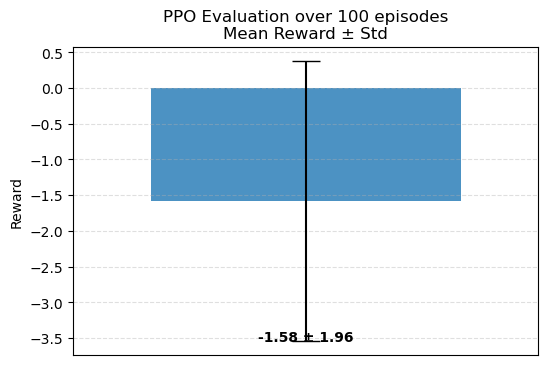

In [33]:
# cell: eval
from stable_baselines3 import PPO
import gymnasium as gym
from stable_baselines3.common.evaluation import evaluate_policy

eval_env = make_tetris_env()( )  # single env instance
model = PPO.load("ppo_tetris_model_v1", env=eval_env)

mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=100, deterministic=True)
print(f"Eval mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

# If you want to render a single episode and inspect:
obs, _ = eval_env.reset()
done = False
ep_reward = 0
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(int(action))
    ep_reward += reward
    done = terminated or truncated

print("Episode reward:", ep_reward)
eval_env.close()


# visualize mean and std returned by evaluate_policy
plt.figure(figsize=(6,4))
plt.bar(0, mean_reward, yerr=std_reward, capsize=10, color='C0', alpha=0.8)
plt.xlim(-0.6, 0.6)
plt.xticks([])  # no x-axis labels for a single-bar plot
plt.ylabel('Reward')
plt.title('PPO Evaluation over 100 episodes\nMean Reward ± Std')
plt.text(0, mean_reward + np.sign(mean_reward + 1e-8) * (std_reward + 0.05),
         f'{mean_reward:.2f} ± {std_reward:.2f}',
         ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [31]:
import gymnasium as gym
import numpy as np
import imageio
from stable_baselines3 import PPO

# 1. Load your trained model
model = PPO.load("ppo_tetris_model_v1")

# 2. Recreate environment with render_mode='rgb_array'
env = make_tetris_env(render_mode='rgb_array')()  # if your make_tetris_env supports args
obs, _ = env.reset()

frames = []
done = False
total_reward = 0

for step in range(2000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward

    # now render() returns the RGB array directly
    frame = env.render()
    frames.append(frame)

    if done or truncated:
        obs, _ = env.reset()

# 4. Save video
output_path = "ppo_tetris_play.mp4"
imageio.mimsave(output_path, frames, fps=30)

print(f"✅ Video saved to {output_path}")
print(f"Total reward accumulated: {total_reward:.2f}")

env.close()


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (340, 240) to (352, 240) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ Video saved to ppo_tetris_play.mp4
Total reward accumulated: -13.87


In [ ]:
tuned_params = {
    "episodes": 2000,          # short training duration
    "batch_size": 64,          # small batch, faster but noisier updates
    "gamma": 0.99,             # typical default discount factor
    "lr": 0.001,              # faster learning rate (less stable)
    "epsilon_start": 1.0,      # full exploration at start
    "epsilon_end": 0.05,        # mild exploration at the end
    "epsilon_decay": 25000,     # fast decay (less exploration overall)
    "target_update": 1000,     # frequent target refreshes
    "buffer_size": 3000      # smaller replay buffer
}

In [ ]:
# GGZ!!
 
q_net, rewards = train_dqn(**tuned_params)

In [ ]:
# Plot rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Rewards over Episodes')
plt.show()

#### Video Recording (Default)

In [ ]:
import imageio
import torch
import gymnasium as gym
import numpy as np
import os
import re

env = gym.make("tetris_gymnasium/Tetris", render_mode="rgb_array")  # use rgb_array for frames
env = TetrisObsWrapper(env)

# Folder for saving videos
video_dir = "tetris_videos"
os.makedirs(video_dir, exist_ok=True)

# Pattern: tetris_dqn_<number>.mp4
existing = [
    f for f in os.listdir(video_dir)
    if re.match(r"tetris_dqn_tuned-params_(\d+)\.mp4", f)
]

if existing:
    # Extract numbers from filenames and find the largest one
    last_num = max(int(re.search(r"tetris_dqn_tuned-params_(\d+)\.mp4", f).group(1)) for f in existing)
    next_num = last_num + 1
else:
    next_num = 1

# Build next video filename
video_path = os.path.join(video_dir, f"tetris_dqn_tuned-params_{next_num}.mp4")
writer = imageio.get_writer(video_path, fps=30)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_net.eval()

for ep in range(10):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        # convert state (numpy) to torch tensor and add batch dim
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            action = q_net(state_tensor).argmax(1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        # render as rgb_array and write to video
        frame = env.render()
        writer.append_data(frame)

        state = next_state

    print(f"Episode {ep + 1} finished with reward {total_reward:.3f}")

writer.close()
env.close()
print(f"🎬 Video saved to {video_path}")


In [ ]:
Video("tetris_videos/tetris_dqn_tuned-params_2.mp4", embed=True)

### **Actor Critic**

In [ ]:
# # =============================
# # 📊 Evaluate trained Tetris DQN agent
# # =============================

# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# import gymnasium as gym
# from collections import defaultdict

# # --- define evaluation function ---
# def evaluate_agent(policy_net,
#                    env_fn,
#                    n_episodes=100,
#                    device='cuda' if torch.cuda.is_available() else 'cpu',
#                    render=False,
#                    render_mode='ansi',
#                    collect_shaped=True):

#     policy_net.eval()
#     stats = defaultdict(list)

#     for ep in range(n_episodes):
#         env = env_fn()
#         obs, _ = env.reset()
#         state = np.array(obs, dtype=np.float32)
#         done = False
#         total_reward = 0.0
#         total_shaped = 0.0 if collect_shaped else None
#         steps = 0

#         with torch.no_grad():
#             while not done:
#                 s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
#                 q_values = policy_net(s)
#                 action = q_values.argmax(1).item()

#                 next_obs, reward, terminated, truncated, info = env.step(action)
#                 next_state = np.array(next_obs, dtype=np.float32)
#                 done = terminated or truncated

#                 total_reward += reward
#                 if collect_shaped:
#                     shaped = -0.01 if reward == 0 else reward * 10
#                     total_shaped += shaped

#                 state = next_state
#                 steps += 1

#         env.close()

#         stats['episode_reward_raw'].append(total_reward)
#         if collect_shaped:
#             stats['episode_reward_shaped'].append(total_shaped)
#         stats['episode_steps'].append(steps)

#         print(f"Episode {ep+1}/{n_episodes} | Lines Cleared: {total_reward:.0f} | Steps: {steps}")

#     # --- summary metrics ---
#     metrics = {
#         'mean_reward_raw': np.mean(stats['episode_reward_raw']),
#         'std_reward_raw': np.std(stats['episode_reward_raw']),
#         'max_reward_raw': np.max(stats['episode_reward_raw']),
#         'mean_steps': np.mean(stats['episode_steps'])
#     }
#     if collect_shaped:
#         metrics['mean_reward_shaped'] = np.mean(stats['episode_reward_shaped'])

#     print("\n=== Evaluation Summary ===")
#     for k, v in metrics.items():
#         print(f"{k:20s}: {v:.2f}")

#     # --- plot ---
#     plt.figure(figsize=(10,4))
#     plt.plot(stats['episode_reward_raw'], label='Raw (Lines Cleared)')
#     if collect_shaped:
#         plt.plot(stats['episode_reward_shaped'], label='Shaped Reward')
#     plt.xlabel('Episode')
#     plt.ylabel('Reward')
#     plt.title('DQN Evaluation over 100 Episodes')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return metrics, stats


# # --- run evaluation ---
# env_ctor = lambda: TetrisObsWrapper(gym.make("tetris_gymnasium/Tetris", render_mode="ansi"))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # replace `q_net` with whatever your trained model variable name is
# metrics, stats = evaluate_agent(q_net, env_ctor, n_episodes=1000, device=device, collect_shaped=True)
